# Training a Neural Network with the MNIST Fashion Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import NeuralNetwork as NN

%matplotlib inline

### Reading the Data

This dataset can be downloaded from the nnfs website, from which the Neural Network was based.

In [3]:
from zipfile import ZipFile
import os
import urllib

URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)
    
print('Unzipping Images...')
with ZipFile(FILE) as zip_images:
    zip_images.extractall(FOLDER)

print('Done!')

Unzipping Images...
Done!


### Looking into some data

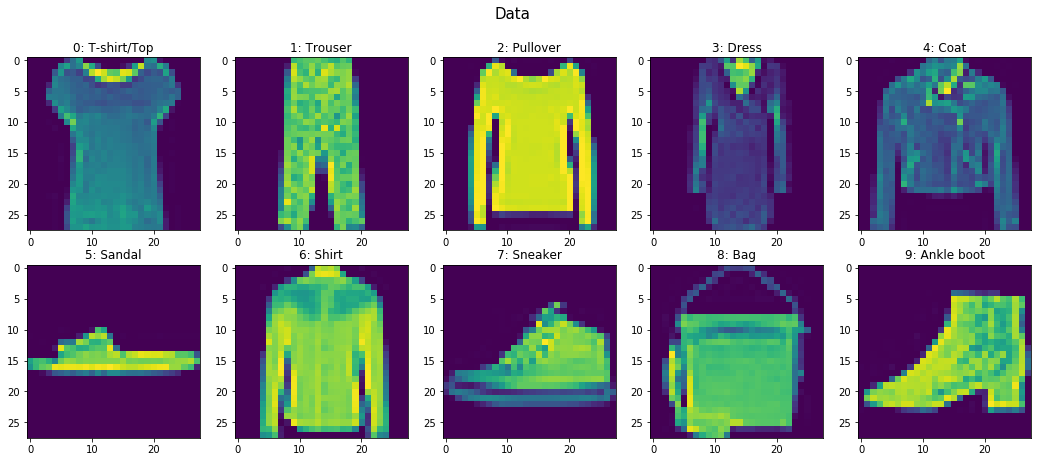

In [4]:
dict_fashion = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',
               6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

image_data = []
for fold in range(10):
    image_data.append(cv2.imread('fashion_mnist_images/train/'+str(fold)+'/0100.png', cv2.IMREAD_UNCHANGED))
    
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(18,7))

for i in range(5):
    ax[0][i].imshow(image_data[i]); ax[0][i].set_title(str(i)+': '+dict_fashion[i])
    ax[1][i].imshow(image_data[5+i]); ax[1][i].set_title(str(5+i)+': '+dict_fashion[5+i])

_ = fig.suptitle('Data', fontsize=15)

### Loading all the MNIST data

In [5]:
def load_mnist_dataset(dataset, path):
    
    # Scan all the directories and create a list with their names. In this case will be
    # ['0', '1', ....., '9']
    labels = os.listdir(os.path.join(path,dataset))
    
    X = []; y = []  #Creating list to save samples and labels
    
    # Iterate over all directories and figures inside them
    for label in labels:
        for file in os.listdir(os.path.join(path,dataset,label)):
            X.append(cv2.imread(os.path.join(path,dataset,label,file),
                               cv2.IMREAD_UNCHANGED))
            y.append(label)
            
    return np.array(X), np.array(y).astype('uint8')

def create_data_mnist(path):
    
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)
    
    return X,y, X_test, y_test

# Loading all data
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

### Shuffling, rescaling and reshaping the data

In [6]:
# Shuffle
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

# Rescale the data. Our images are 2D 28x28 arrays with elements from 0 to 255. We will convert those elementes
# to the range from -1 to 1 for a better performance of our Neural Network
X = (X - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

# Reshape the data to transform the figures into 1D arrays to used as input data for our Neural Network
X = X.reshape(X.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0], -1)

### Training our Model

We will use 2 hidden layers with 128 layers each; L2 regularization in the first layer; layer dropout with a rate of 10%; Categorical Cross Etropy for the Loss and the Adam Optimizer

In [7]:
model = NN.Model()

model.add(NN.Layer_Dense(X.shape[1],128, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4))
model.add(NN.Activation_ReLU())
model.add(NN.Layer_Dropout(0.1))
model.add(NN.Layer_Dense(128,10))
model.add(NN.Activation_Softmax())

model.set(
    loss = NN.Loss_CategoricalCrossEntropy(),
    optimizer = NN.Optimizer_Adam(learning_rate = 0.001, decay=5e-5),
    accuracy = NN.Accuracy_Categorical())

model.finalize()

model.train(X, y, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1 training, acc: 0.789, loss: 0.637 (data_loss: 0.595, reg_loss: 0.042), lr: 0.0009771350400625365
VALIDATION, acc: 0.829, loss: 0.477
Epoch 2 training, acc: 0.847, loss: 0.476 (data_loss: 0.428, reg_loss: 0.048), lr: 0.0009552466924583273
VALIDATION, acc: 0.847, loss: 0.433
Epoch 3 training, acc: 0.859, loss: 0.443 (data_loss: 0.393, reg_loss: 0.050), lr: 0.000934317481080071
VALIDATION, acc: 0.852, loss: 0.415
Epoch 4 training, acc: 0.867, loss: 0.423 (data_loss: 0.371, reg_loss: 0.052), lr: 0.0009142857142857143
VALIDATION, acc: 0.856, loss: 0.405
Epoch 5 training, acc: 0.872, loss: 0.409 (data_loss: 0.356, reg_loss: 0.053), lr: 0.0008950948800572861
VALIDATION, acc: 0.860, loss: 0.391
Epoch 6 training, acc: 0.877, loss: 0.398 (data_loss: 0.344, reg_loss: 0.054), lr: 0.0008766931135755929
VALIDATION, acc: 0.859, loss: 0.394
Epoch 7 training, acc: 0.880, loss: 0.387 (data_loss: 0.333, reg_loss: 0.055), lr: 0.0008590327291469806
VALIDATION, acc: 0.863, loss: 0.383
Epoch 8 traini

In [9]:
model.save('Fashion_Recognizer.model')

### Predictions with some google images

In [10]:
dict_fashion = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',
               6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}
ticks_labels = [dict_fashion[i] for i in range(10)]

#Load model
model = NN.Model.load('Fashion_Recognizer.model')

def predict_images(filename):
    image_real = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    image_test = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    image_test = cv2.resize(image_test, (28,28))
    image_pred = (image_test.flatten() - 127.5) / 127.5
    pred = model.forward(image_pred, training=False)

    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5))
    ax[1].bar(range(10), pred.flatten())
    ax[0].imshow(image_real)
    _ = ax[1].set_xticks(ticks=range(10))
    _ = ax[1].set_xticklabels(labels=ticks_labels, rotation=30)
    _ = ax[1].set_ylabel('Probability')
    _ = ax[0].set_title(f'This is probably a {ticks_labels[np.argmax(pred)]} !', fontsize=15)

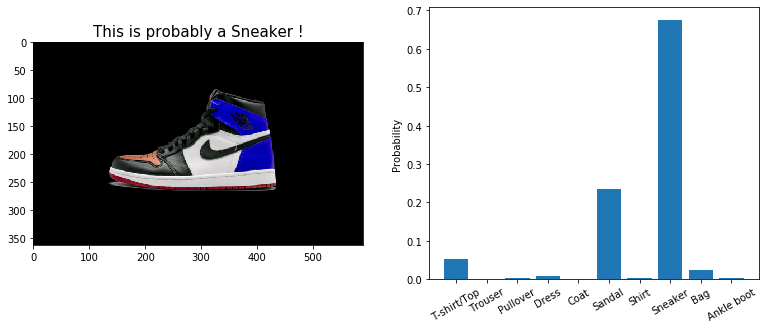

In [11]:
predict_images('Sneaker_test.png')

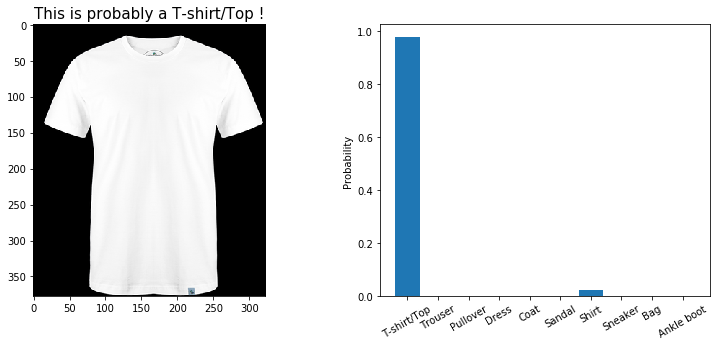

In [12]:
predict_images('Tshirt_test.png')